In [1]:
# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()

import importlib
from libs import trades, plots, params, models
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)

import pandas as pd
import numpy as np
import math

from pathlib import Path
import pickle
import datetime as dt
from datetime import datetime

import matplotlib.pyplot as plt   
import seaborn as sns
from pprint import pprint

import torch
import torch.nn.functional as Funct
from torch.utils.data import Dataset, DataLoader
torch.serialization.add_safe_globals([models.DayWindowDataset])

from tqdm.auto import tqdm

import io
from PIL import Image
import IPython.display as disp

In [2]:
device               = params.device
ticker               = params.ticker
save_path            = params.save_path
pred_threshold       = params.pred_threshold_tick
regular_start        = params.regular_start
regular_start_pred   = params.regular_start_pred
regular_start_shifted= params.regular_start_shifted
regular_end          = params.regular_end
look_back            = params.look_back_tick
trailing_stop_thresh = params.trailing_stop_thresh_tick

# model path
val_rmse_str = "0.2478"   # same rmse in the filename

path_csv_load = save_path / f"{ticker}_final.csv"
path_csv_save = save_path / f"{ticker}_test_DF.csv"

model_path = save_path / f"{ticker}_{val_rmse_str}.pth"
model_path

PosixPath('dfs_training/GOOGL_0.2478.pth')

In [3]:
df = pd.read_csv(path_csv_load, index_col=0, parse_dates=True)
df

open      high      low     close    atr_14  \
2014-04-03 08:49:00   28.650   28.6500   28.650   28.6500  0.000000   
2014-04-03 08:50:00   28.650   28.6500   28.650   28.6500  0.000000   
2014-04-03 08:51:00   28.650   28.6500   28.650   28.6500  0.000000   
2014-04-03 08:52:00   28.650   28.6500   28.650   28.6500  0.000000   
2014-04-03 08:53:00   28.650   28.6500   28.650   28.6500  0.000000   
...                      ...       ...      ...       ...       ...   
2025-06-18 20:56:00  173.375  173.6771  173.215  173.5650  0.304529   
2025-06-18 20:57:00  173.565  173.5900  173.240  173.3800  0.317029   
2025-06-18 20:58:00  173.390  173.4100  173.200  173.3100  0.323814   
2025-06-18 20:59:00  173.315  173.4000  173.230  173.2800  0.322743   
2025-06-18 21:00:00  173.300  174.0500  173.170  173.6097  0.374521   

                         vwap_dev  bb_width_20       ma_5       ma_20  \
2014-04-03 08:49:00  1.240040e-16     0.000000   28.65000   28.650000   
2014-04-03 08:50:00  1.240040e-16     0.000000   28.65000   28.650000   
2014-04-03 08:51:00  1.240040e-16     0.000000   28.65000   28.650000   
2014-04-03 08:52:00  1.240040e-16     0.000000   28.65000   28.650000   
2014-04-03 08:53:00  1.240040e-16     0.000000   28.65000   28.650000   
...                           ...          ...        ...         ...   
2025-06-18 20:56:00  1.257638e+00     0.014819  173.91300  174.838390   
2025-06-18 20:57:00  1.255215e+00     0.016242  173.73700  174.736890   
2025-06-18 20:58:00  1.254293e+00     0.017430  173.53500  174.634390   
2025-06-18 20:59:00  1.253874e+00     0.018221  173.38100  174.527890   
2025-06-18 21:00:00  1.257962e+00     0.018282  173.42894  174.442375   

                     macd_12_26           obv  in_trading  hour         bid  \
2014-04-03 08:49:00    0.000000  0.000000e+00           0     8   28.641405   
2014-04-03 08:50:00    0.000000  0.000000e+00           0     8   28.641405   
2014-04-03 08:51:00    0.000000  0.000000e+00           0     8   28.641405   
2014-04-03 08:52:00    0.000000  0.000000e+00           0     8   28.641405   
2014-04-03 08:53:00    0.000000  0.000000e+00           0     8   28.641405   
...                         ...           ...         ...   ...         ...   
2025-06-18 20:56:00   -0.422065  4.758230e+08           1    20  173.512900   
2025-06-18 20:57:00   -0.466939  4.751988e+08           1    20  173.328000   
2025-06-18 20:58:00   -0.502359  4.747443e+08           1    20  173.258000   
2025-06-18 20:59:00   -0.526778  4.736496e+08           1    20  173.228000   
2025-06-18 21:00:00   -0.513606  4.812994e+08           0    21  173.557600   

                            ask  signal_smooth  
2014-04-03 08:49:00   28.658595       0.219822  
2014-04-03 08:50:00   28.658595       0.220376  
2014-04-03 08:51:00   28.658595       0.220931  
2014-04-03 08:52:00   28.658595       0.221487  
2014-04-03 08:53:00   28.658595       0.222044  
...                         ...            ...  
2025-06-18 20:56:00  173.617100       0.002995  
2025-06-18 20:57:00  173.432000       0.002906  
2025-06-18 20:58:00  173.362000       0.005611  
2025-06-18 20:59:00  173.332000       0.006685  
2025-06-18 21:00:00  173.661800       0.003506  

[2117801 rows x 16 columns]

{'ATT_DROPOUT': 0.3,
 'ATT_HEADS': 8,
 'CLIPNORM': 1,
 'DROPOUT_LONG': 0.4,
 'DROPOUT_SHORT': 0.35,
 'EARLY_STOP_PATIENCE': 8,
 'ETA_MIN': 4e-05,
 'INITIAL_LR': 0.0009,
 'LONG_UNITS': 92,
 'LR_EPOCHS_WARMUP': 0,
 'MAX_EPOCHS': 60,
 'MIN_LR': 1e-06,
 'NUM_WORKERS': 2,
 'PLATEAU_FACTOR': 0.9,
 'PLATEAU_PATIENCE': 0,
 'PLAT_EPOCHS_WARMUP': 999,
 'SHORT_UNITS': 64,
 'TRAIN_BATCH': 32,
 'TRAIN_PREFETCH_FACTOR': 1,
 'T_0': 60,
 'T_MULT': 1,
 'VAL_BATCH': 1,
 'WEIGHT_DECAY': 0.0001}


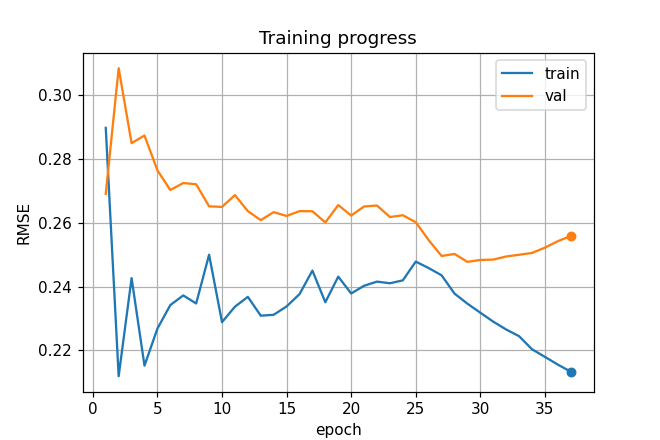

DualMemoryLSTM(
  (short_lstm): LSTM(13, 64, batch_first=True)
  (attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
  )
  (do_short): Dropout(p=0.35, inplace=False)
  (ln_short): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (long_lstm): LSTM(64, 92, batch_first=True)
  (do_long): Dropout(p=0.4, inplace=False)
  (ln_long): LayerNorm((92,), eps=1e-05, elementwise_affine=True)
  (pred): Linear(in_features=92, out_features=1, bias=True)
)

In [4]:
# Load the entire model object (architecture + weights)# 1) load your checkpoint dict
ckpt = torch.load(model_path, map_location=device, weights_only=False)

# 2) grab the full model object you saved
model_best = ckpt["model_obj"]

# 3) move to device and set eval mode
model_best = model_best.to(device).eval()

# 4) show parameters, training plot, and model
saved_hparams = ckpt["hparams"]
pprint(saved_hparams)

png_bytes = ckpt.get("train_plot_png")
img = Image.open(io.BytesIO(png_bytes))
disp.display(img)

model_best


In [5]:

print('executing <build_lstm_tensors>...')
X, y, raw_close, raw_bid, raw_ask = models.build_lstm_tensors(
    df=df,
    look_back=look_back,
    features_cols=params.features_cols,
    label_col=params.label_col,
    regular_start=regular_start_pred 
)

print('executing <chronological_split>...')
(X_tr, y_tr), \
(X_val, y_val), \
(X_te, y_te, raw_close_te, raw_bid_te, raw_ask_te), \
samples_per_day, day_id_tr, day_id_val, day_id_te = models.chronological_split(
    X, y, raw_close, raw_bid, raw_ask, df,
    look_back    = look_back,
    regular_start=regular_start_pred, 
    train_prop   = params.train_prop,
    val_prop     = params.val_prop,
    train_batch  = params.hparams['TRAIN_BATCH']
)

print('executing <split_to_day_datasets>...')
train_loader, val_loader, test_loader = models.split_to_day_datasets(
    # Training split arrays (from chronological_split)
    X_tr, y_tr, day_id_tr,
    # Validation split arrays
    X_val, y_val, day_id_val,
    # Test split arrays + raw prices for post‐tracking
    X_te, y_te, day_id_te, raw_close_te, raw_bid_te, raw_ask_te,
    # Original minute‐bar DataFrame for weekday mapping
    df=df,
    train_batch=params.hparams['TRAIN_BATCH'],
    train_workers=params.hparams['NUM_WORKERS']
)

print('dataloaders generated!')

executing <build_lstm_tensors>...
executing <chronological_split>...
executing <split_to_day_datasets>...
▶️ Entered split_to_day_datasets
1) building weekday arrays
   Weekdays counts → tr=1132845, val=236394, te=240962
2) moving all splits to CPU
   CPU casts done
3) zero-bas­ing day_id for val & test
   val_day_id ∈ [0..413], total days=414
   te_day_id  ∈ [0..421], total days=422
4) instantiating DayWindowDatasets
   ds_tr days: 1984
   ds_val days: 414
   ds_te days: 422
5) building DataLoaders
   train_loader ready
   val_loader ready
   test_loader ready
dataloaders generated!


In [6]:
# zero‐forecast baseline on val vs test
# √( mean( (yᵢ – 0)² ) )

val_baseline  = models.naive_rmse(val_loader)
test_baseline = models.naive_rmse(test_loader)

print(f"Val zero‐forecast baseline RMSE  = {val_baseline:.5f}")
print(f"Test zero‐forecast baseline RMSE = {test_baseline:.5f}")

Val zero‐forecast baseline RMSE  = 0.51801
Test zero‐forecast baseline RMSE = 0.55302


std val: 0.32973263
std test: 0.34039408


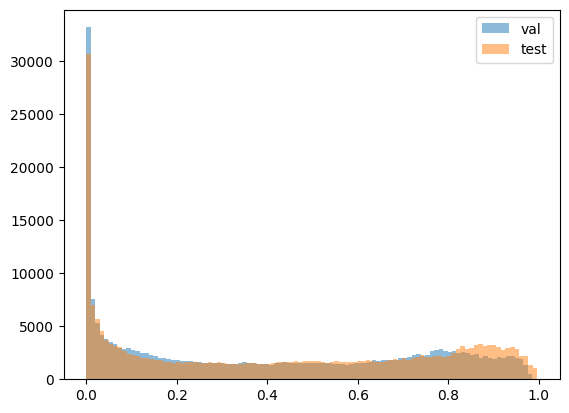

In [7]:
# to confirm the baseline proportions, calculate the STD
# σ = √( mean( (yᵢ – ȳ)² ) )

y_vals = np.concatenate([batch[1].view(-1).numpy()
                         for batch in val_loader])
y_tes  = np.concatenate([batch[1].view(-1).numpy()
                         for batch in test_loader])
print("std val:", np.std(y_vals))
print("std test:", np.std(y_tes))

plt.hist(y_vals, bins=100, alpha=0.5, label="val")
plt.hist(y_tes,  bins=100, alpha=0.5, label="test")
plt.legend(); plt.show()

In [8]:
def evaluate_model(
    model: torch.nn.Module,
    loader: torch.utils.data.DataLoader,
    device: torch.device,
    split_name: str = "Test"
):
    """
    Run your LSTM over every day in `loader`, with the same reset logic
    you use in rmse_over_windows and collect_predictions, but controlled by flags:

    Returns:
      (rmse, preds) where:
        • rmse is a float if compute_rmse else None
        • preds is a 1D np.ndarray if collect_preds else None
    """
    # Move model & reset its internal state
    model.to(device).eval()
    model.h_short = model.h_long = None

    prev_wd        = None
    total_sq_error = 0.0     # for RMSE
    total_windows  = 0       # counter for windows
    all_preds      = []      # list to store per-day preds

    # Iterate exactly as in two original functions
    with torch.no_grad():
        for batch in tqdm(loader, desc=f"{split_name}", unit="day"):
            # Unpack: xb_day, yb_day, optional raw_*, wd
            xb_day, yb_day, *_, wd = batch
            wd_val = int(wd.item())

            # reset per-day LSTM
            model.reset_short()
            # reset per-week LSTM on weekday wrap
            if prev_wd is not None and wd_val < prev_wd:
                model.reset_long()
            prev_wd = wd_val

            # pull input windows and true targets
            x    = xb_day[0].to(device)        # shape: (W, look_back, F)
            y    = yb_day.view(-1).to(device)  # shape: (W,)

            # forward pass → get last-step prediction
            out  = model(x)                    # (W, look_back, 1)
            pred = out[:, -1, 0]               # (W,)

            # accumulate RMSE stats
            total_sq_error += (pred - y).pow(2).sum().item()
            total_windows  += y.numel()

            all_preds.append(pred.cpu().numpy())

    # compute final RMSE
    rmse = None
    rmse = math.sqrt(total_sq_error / total_windows)
    print(f"\n{split_name} RMSE over {total_windows} windows = {rmse:.5f}")

    # flatten collected predictions
    preds = None
    preds = np.concatenate(all_preds, axis=0)

    return rmse, preds


In [9]:
val_rmse, val_preds     = evaluate_model(model_best, val_loader, device, split_name="Validation")
test_rmse, test_preds   = evaluate_model(model_best, test_loader, device, split_name="Test")

test_preds.shape

Validation:   0%|          | 0/414 [00:00<?, ?day/s]


Validation RMSE over 236394 windows = 0.25588


Test:   0%|          | 0/422 [00:00<?, ?day/s]


Test RMSE over 240962 windows = 0.28950


(240962,)

In [10]:
def add_pred_actions(
    df: pd.DataFrame,
    preds: np.ndarray,
    look_back: int,
    day_id_te: np.ndarray,
    pred_threshold: float,
    trailing_stop_thresh: float,
    regular_start_shifted: datetime.time,
    path_csv_save: str
) -> pd.DataFrame:
    """
    Returns a full-day DataFrame augmented with
      - pred_signal (NaN outside test-window)
      - pred_action (integer: -1/0/+1 everywhere)
    so downstream sim & plotting see the full x-axis.
    """
    # 1) Copy & init columns
    df_out = df.copy()
    df_out["pred_signal"] = np.nan
    df_out["pred_action"] = 0  # default: no trade

    # 2) Identify test‐days by index normalize & map via day_id_te
    all_days = sorted(df_out.index.normalize().unique())
    test_ids = np.unique(day_id_te).astype(int)
    test_days = [all_days[i] for i in test_ids]

    # 3) Build mask of all post-start rows on test days
    mask = (
        df_out.index.normalize().isin(test_days)
        & (df_out.index.time >= regular_start_shifted) 
    )
    cand = df_out.loc[mask]

    # 4) Within each test day, drop the initial look_back rows
    valid_idx = (
        cand
        .groupby(cand.index.normalize(), sort=False)
        .apply(lambda g: g.index[look_back:])
        .explode()
    )
    valid_idx = pd.DatetimeIndex(valid_idx.values)

    # 5) Stamp your model’s predictions on those valid slots
    if len(valid_idx) != len(preds):
        raise ValueError(
            f"Expected {len(valid_idx)} prediction slots, got {len(preds)} preds"
        )
    df_out.loc[valid_idx, "pred_signal"] = preds

    # 6) Generate & write back integer actions per test day
    for day in test_days:
        # slice just that day
        day_slice = df_out[df_out.index.normalize() == day]

        # generate_trade_actions expects pred_signal + writes pred_action
        day_actions = trades.generate_trade_actions(
            df                   = day_slice,
            col_signal           = "pred_signal",
            col_action           = "pred_action",
            buy_threshold        = pred_threshold,
            trailing_stop_thresh = trailing_stop_thresh,
            regular_start        = params.regular_start
        )

        # overwrite int actions only on real trade timestamps
        df_out.loc[day_actions.index, "pred_action"] = (
            day_actions["pred_action"]
            .fillna(0)
            .astype(int)
        )

    # 7) (Optional) persist for inspection
    df_out.to_csv(path_csv_save)

    return df_out


In [22]:
df_with_preds = add_pred_actions(
    df, test_preds, look_back,
    day_id_te, pred_threshold,
    trailing_stop_thresh, regular_start_shifted,
    path_csv_save
).dropna(subset=["pred_signal"]) # to keep only rows where the model actually put down a signal (the test subset)

df_with_preds

open      high      low     close    atr_14  vwap_dev  \
2023-10-12 11:30:00  141.620  141.6300  141.600  141.6000  0.065714  1.181458   
2023-10-12 11:31:00  141.620  141.7100  141.600  141.7100  0.072857  1.183153   
2023-10-12 11:32:00  141.610  141.6500  141.610  141.6500  0.072143  1.182229   
2023-10-12 11:33:00  141.650  141.6500  141.560  141.5800  0.073571  1.181150   
2023-10-12 11:34:00  141.580  141.5800  141.540  141.5500  0.076429  1.180688   
...                      ...       ...      ...       ...       ...       ...   
2025-06-18 20:56:00  173.375  173.6771  173.215  173.5650  0.304529  1.257638   
2025-06-18 20:57:00  173.565  173.5900  173.240  173.3800  0.317029  1.255215   
2025-06-18 20:58:00  173.390  173.4100  173.200  173.3100  0.323814  1.254293   
2025-06-18 20:59:00  173.315  173.4000  173.230  173.2800  0.322743  1.253874   
2025-06-18 21:00:00  173.300  174.0500  173.170  173.6097  0.374521  1.257962   

                     bb_width_20       ma_5       ma_20  macd_12_26  \
2023-10-12 11:30:00     0.004279  141.62600  141.438000    0.100816   
2023-10-12 11:31:00     0.004393  141.64200  141.461500    0.106901   
2023-10-12 11:32:00     0.004352  141.65200  141.480500    0.105663   
2023-10-12 11:33:00     0.004180  141.62800  141.495500    0.097906   
2023-10-12 11:34:00     0.003936  141.61800  141.509000    0.088319   
...                          ...        ...         ...         ...   
2025-06-18 20:56:00     0.014819  173.91300  174.838390   -0.422065   
2025-06-18 20:57:00     0.016242  173.73700  174.736890   -0.466939   
2025-06-18 20:58:00     0.017430  173.53500  174.634390   -0.502359   
2025-06-18 20:59:00     0.018221  173.38100  174.527890   -0.526778   
2025-06-18 21:00:00     0.018282  173.42894  174.442375   -0.513606   

                              obv  in_trading  hour       bid       ask  \
2023-10-12 11:30:00  4.793747e+08           0    11  141.5575  141.6425   
2023-10-12 11:31:00  4.793758e+08           0    11  141.6675  141.7525   
2023-10-12 11:32:00  4.793745e+08           0    11  141.6075  141.6925   
2023-10-12 11:33:00  4.793743e+08           0    11  141.5375  141.6225   
2023-10-12 11:34:00  4.793741e+08           0    11  141.5075  141.5925   
...                           ...         ...   ...       ...       ...   
2025-06-18 20:56:00  4.758230e+08           1    20  173.5129  173.6171   
2025-06-18 20:57:00  4.751988e+08           1    20  173.3280  173.4320   
2025-06-18 20:58:00  4.747443e+08           1    20  173.2580  173.3620   
2025-06-18 20:59:00  4.736496e+08           1    20  173.2280  173.3320   
2025-06-18 21:00:00  4.812994e+08           0    21  173.5576  173.6618   

                     signal_smooth  pred_signal  pred_action  
2023-10-12 11:30:00       0.069690     0.145116            0  
2023-10-12 11:31:00       0.034898     0.145038            0  
2023-10-12 11:32:00       0.000000     0.145032            0  
2023-10-12 11:33:00       0.000000     0.144965            0  
2023-10-12 11:34:00       0.000000     0.144926            0  
...                            ...          ...          ...  
2025-06-18 20:56:00       0.002995     0.180903            0  
2025-06-18 20:57:00       0.002906     0.192157            1  
2025-06-18 20:58:00       0.005611     0.199915            0  
2025-06-18 20:59:00       0.006685     0.205007            0  
2025-06-18 21:00:00       0.003506     0.207191           -1  

[240962 rows x 18 columns]

In [23]:
# Compute Descriptive Statistics
# Statistics show whether your model systematically over/under-estimates (compare means) and how tightly it tracks (std & correlation).

# assume df is your DataFrame
stats = df_with_preds[['signal_smooth','pred_signal']].describe().T

# add range and error
stats['range'] = stats['max'] - stats['min']
corr = df_with_preds['signal_smooth'].corr(df_with_preds['pred_signal'])
stats['pearson_r_with_other'] = [corr, corr]

print(stats)

                  count      mean       std       min       25%       50%  \
signal_smooth  240962.0  0.435842  0.340395  0.000000  0.076693  0.429842   
pred_signal    240962.0  0.322172  0.182809  0.139681  0.174504  0.240476   

                    75%       max     range  pearson_r_with_other  
signal_smooth  0.768205  0.996222  0.996222              0.629916  
pred_signal    0.434148  0.729248  0.589567              0.629916  


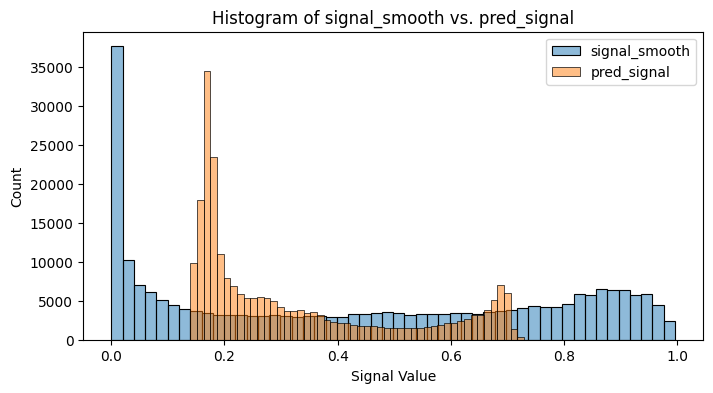

In [24]:
# Distribution Overlay
# Histogram overlay reveals any bias or mismatched shape in the two distributions.

plt.figure(figsize=(8,4))
sns.histplot(df_with_preds['signal_smooth'], color='C0', alpha=0.5, bins=50, label='signal_smooth')
sns.histplot(df_with_preds['pred_signal'],   color='C1', alpha=0.5, bins=50, label='pred_signal')
plt.legend()
plt.xlabel('Signal Value')
plt.ylabel('Count')
plt.title('Histogram of signal_smooth vs. pred_signal')
plt.show()

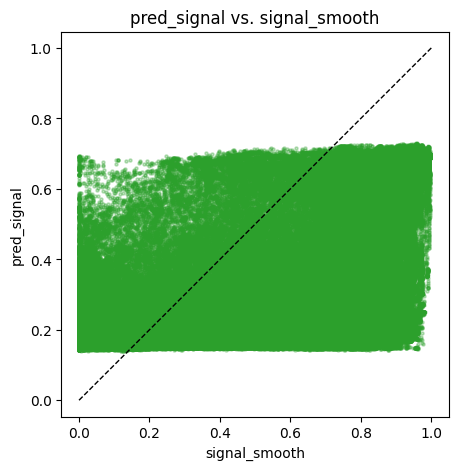

In [25]:
# Scatter Plot: Relationship
# Scatter against the 45° line instantly shows under/over‐prediction regions and non‐linear errors.

plt.figure(figsize=(5,5))
plt.scatter(df_with_preds['signal_smooth'], df_with_preds['pred_signal'],
            s=5, alpha=0.3, color='C2')
plt.plot([0,1],[0,1], 'k--', linewidth=1)  # 45° reference line
plt.xlabel('signal_smooth')
plt.ylabel('pred_signal')
plt.title('pred_signal vs. signal_smooth')
plt.axis('equal')
plt.show()

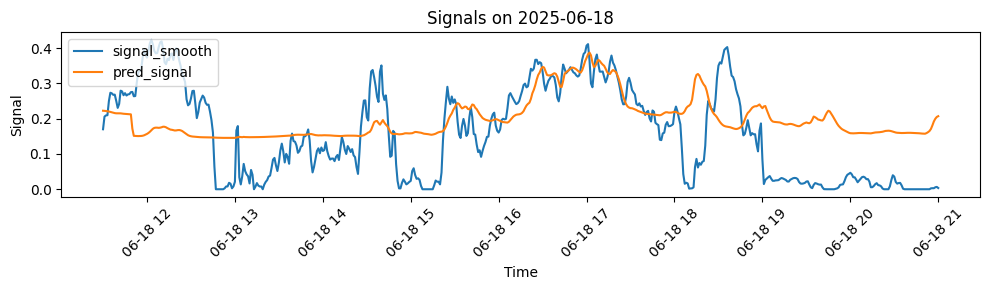

In [26]:
# Time-Series Comparison (Sample)
# Time‐series plots let you see if the model lags or leads the smoothed signal on a given day.

# pick a single day or time span
day = df_with_preds.index.normalize().unique()[-1]
mask = df_with_preds.index.normalize() == day

plt.figure(figsize=(10,3))
plt.plot(df_with_preds.index[mask], df_with_preds.loc[mask,'signal_smooth'], label='signal_smooth')
plt.plot(df_with_preds.index[mask], df_with_preds.loc[mask,'pred_signal'],   label='pred_signal')
plt.legend(loc='upper left')
plt.title(f'Signals on {day.date()}')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

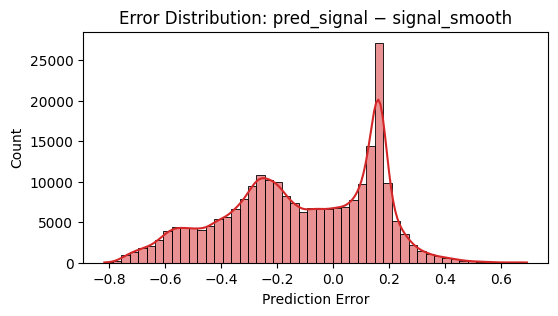

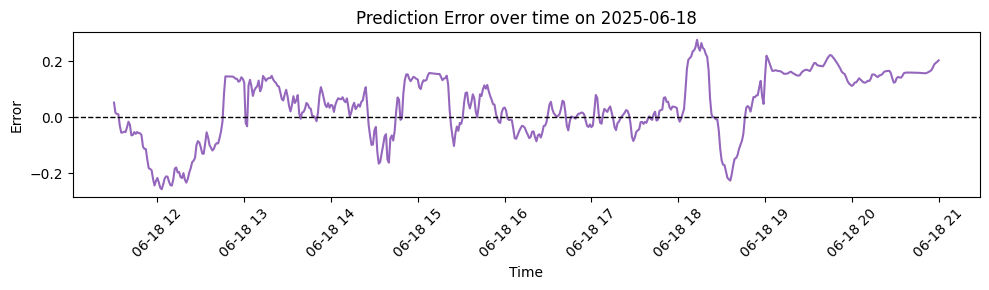

In [27]:
# Error Analysis 
# Error plots quantify where and when the model struggles most, guiding you to fix lag, amplitude scaling, or threshold issues.

# create error column
df_with_preds['error'] = df_with_preds['pred_signal'] - df_with_preds['signal_smooth']

# Distribution of prediction error
plt.figure(figsize=(6,3))
sns.histplot(df_with_preds['error'], bins=50, color='C3', kde=True)
plt.xlabel('Prediction Error')
plt.title('Error Distribution: pred_signal − signal_smooth')
plt.show()

# Time evolution of error on that same sample day
plt.figure(figsize=(10,3))
plt.plot(df_with_preds.index[mask], df_with_preds.loc[mask,'error'], color='C4')
plt.axhline(0, color='k', linestyle='--', linewidth=1)
plt.title(f'Prediction Error over time on {day.date()}')
plt.xlabel('Time')
plt.ylabel('Error')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [28]:
print('generating sim_results as a dict: { date → (df_sim, trades_list, perf_stats) } ...')

# Run the simulator on your DataFrame of predictions/actions
sim_results = trades.simulate_trading(
    results_by_day_sign = df_with_preds,              # DF with pred_action
    col_action          = "pred_action",              # name of the discrete action column
    regular_start       = params.regular_start,   
    regular_end         = params.regular_end,         
    ticker              = params.ticker
)


generating sim_results as a dict: { date → (df_sim, trades_list, perf_stats) } ...



Plotting days in 2024-09:


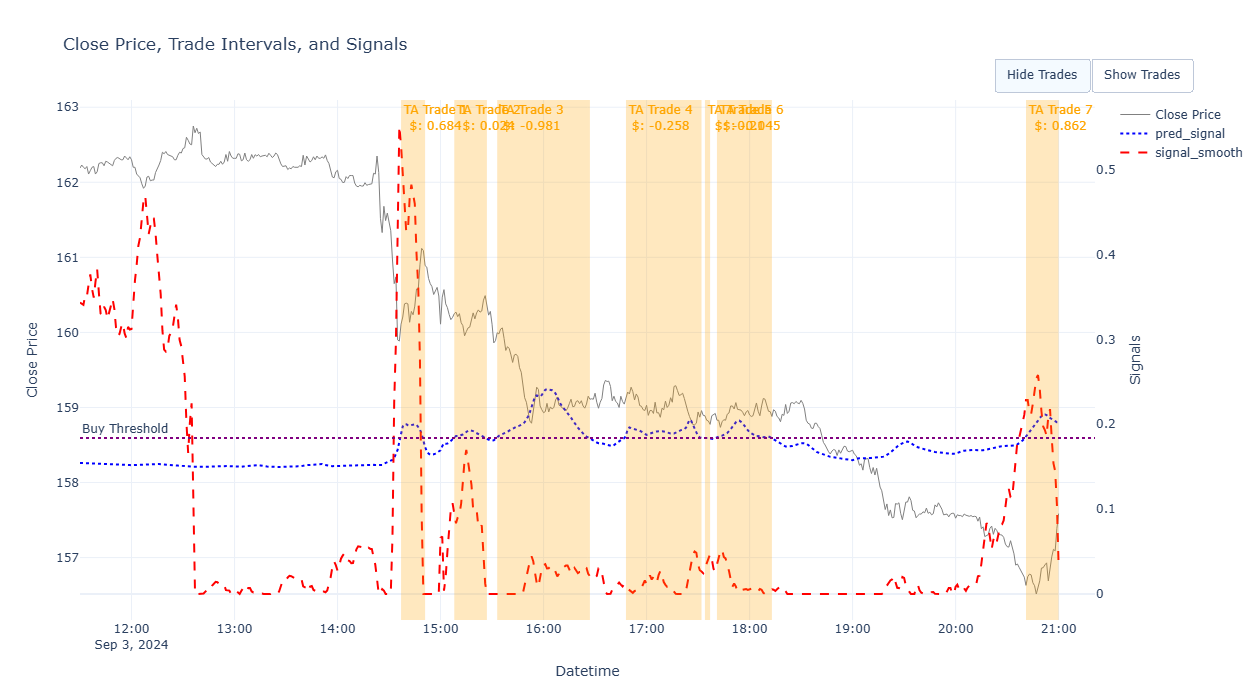


=== Performance for 2024-09-03 00:00:00 ===
Strategy Return ($): -0.12
Buy & Hold Return ($): -4.146
Trades Returns ($): [0.684, 0.024, -0.981, -0.258, -0.21, -0.045, 0.862]


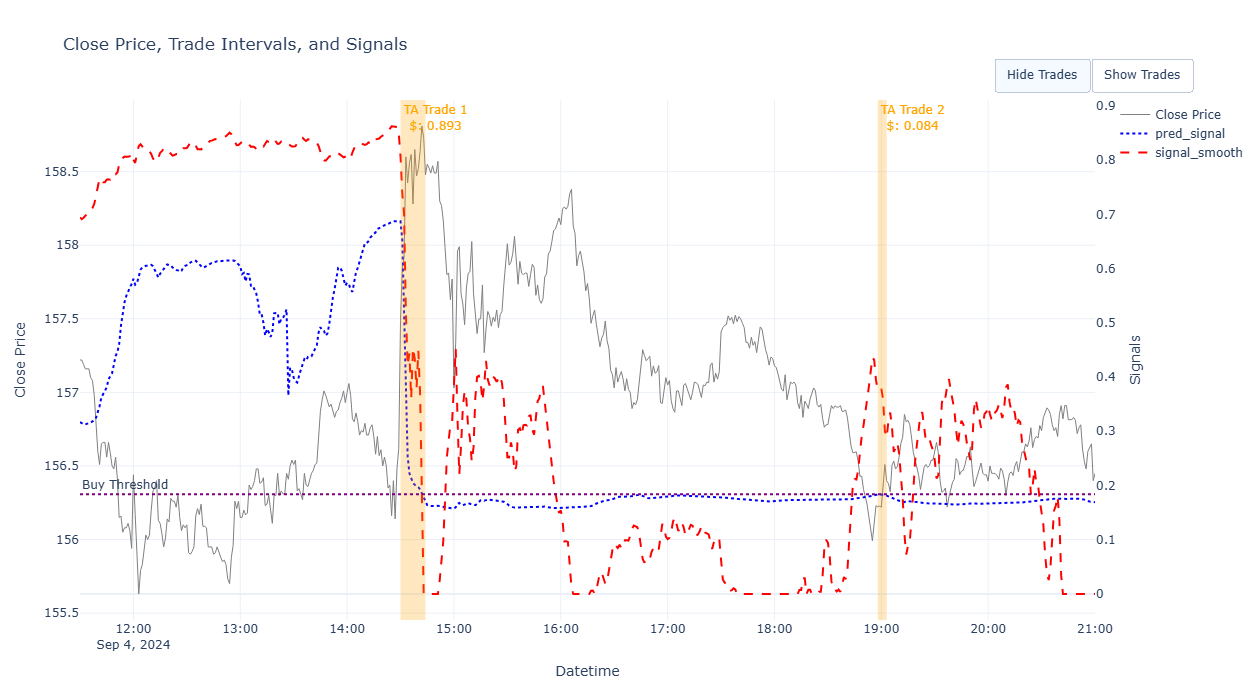


=== Performance for 2024-09-04 00:00:00 ===
Strategy Return ($): 0.977
Buy & Hold Return ($): -1.184
Trades Returns ($): [0.893, 0.084]


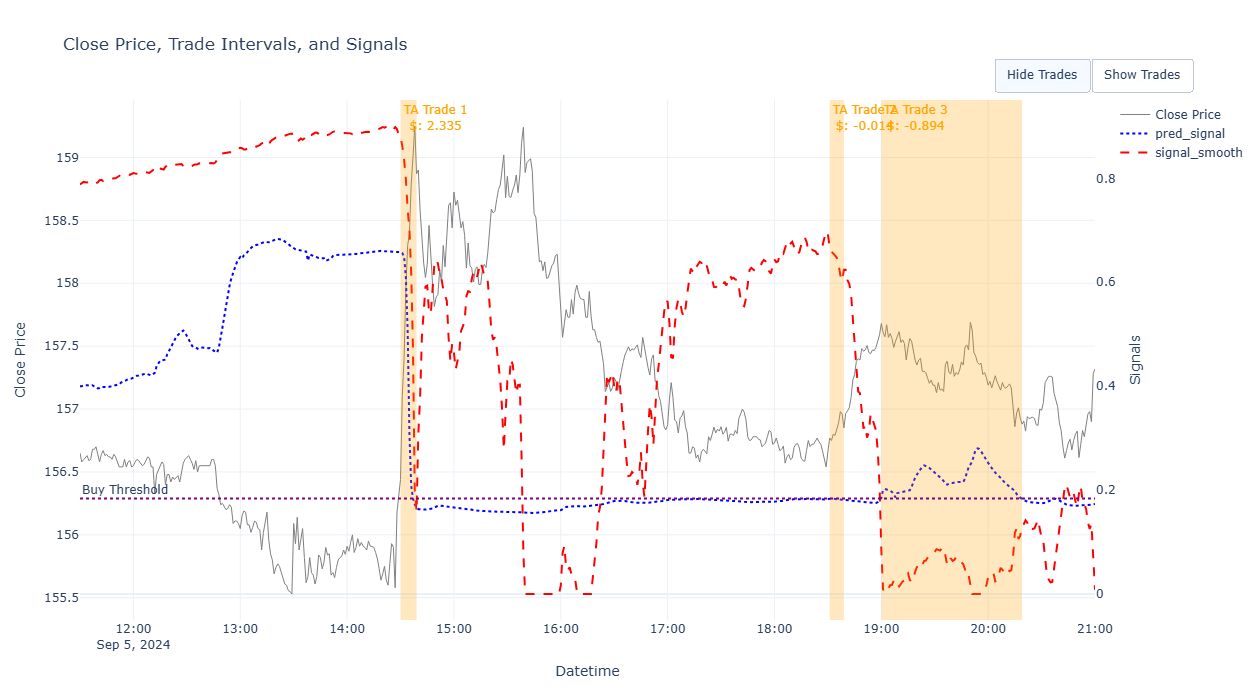


=== Performance for 2024-09-05 00:00:00 ===
Strategy Return ($): 1.427
Buy & Hold Return ($): 0.746
Trades Returns ($): [2.335, -0.014, -0.894]


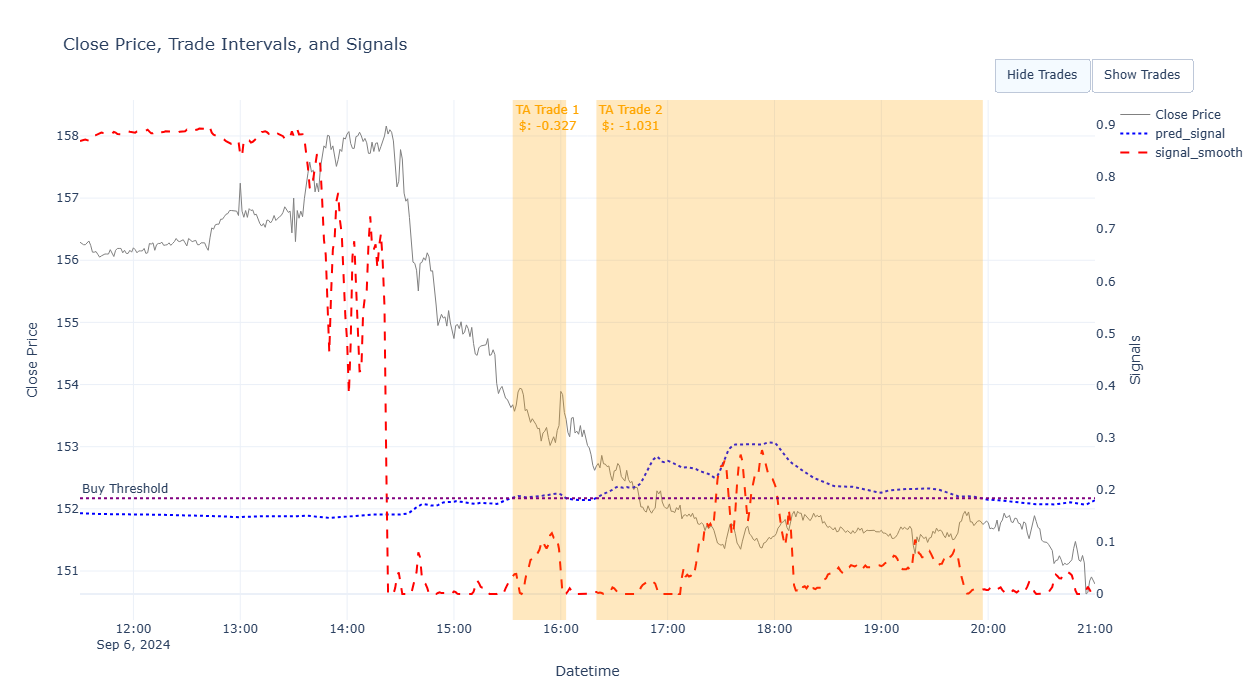


=== Performance for 2024-09-06 00:00:00 ===
Strategy Return ($): -1.358
Buy & Hold Return ($): -7.023
Trades Returns ($): [-0.327, -1.031]


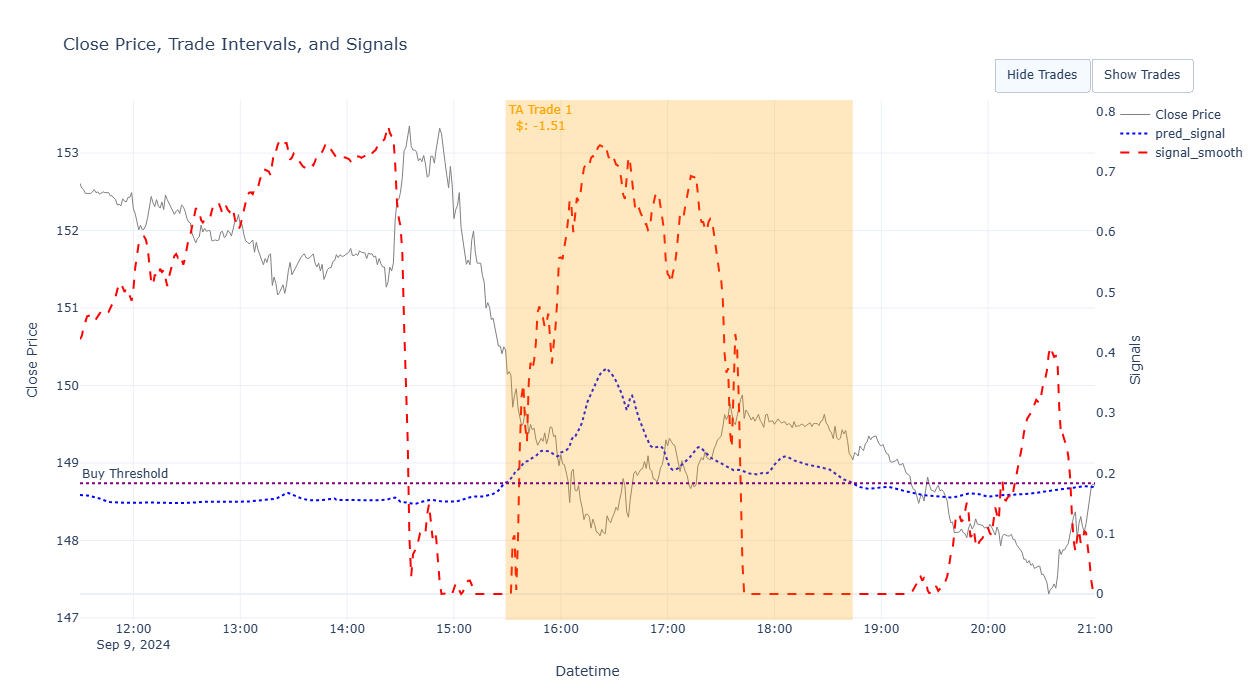


=== Performance for 2024-09-09 00:00:00 ===
Strategy Return ($): -1.51
Buy & Hold Return ($): -3.855
Trades Returns ($): [-1.51]


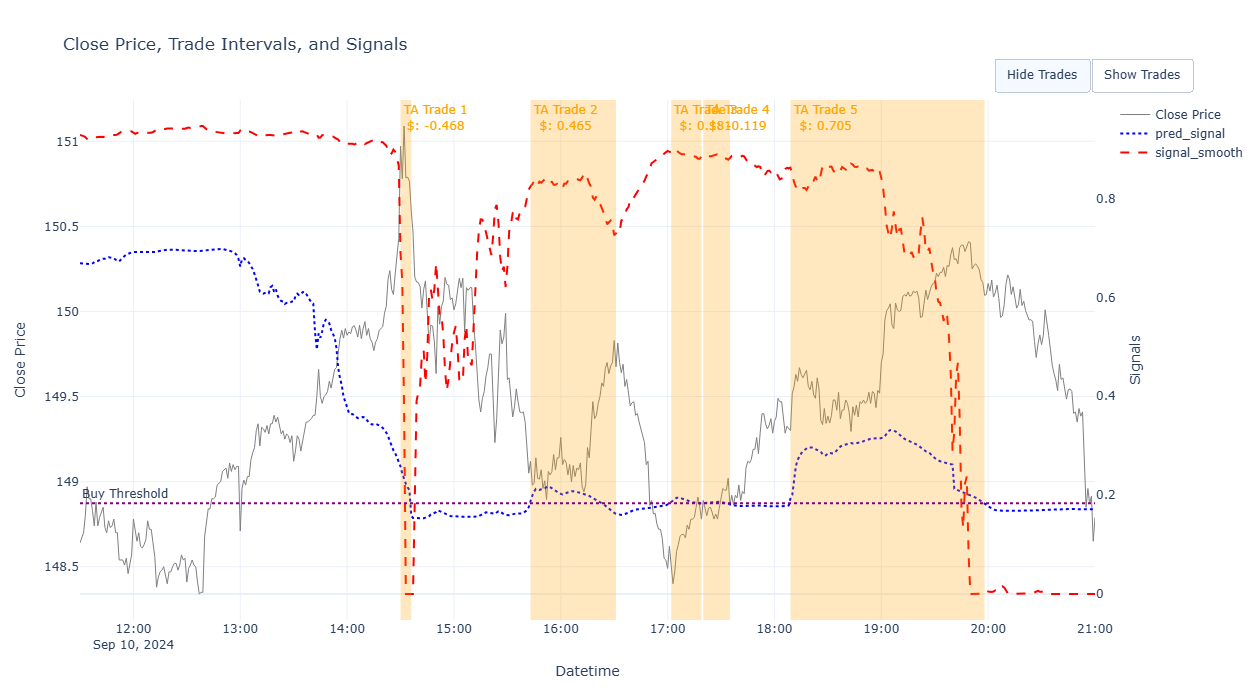


=== Performance for 2024-09-10 00:00:00 ===
Strategy Return ($): 0.764
Buy & Hold Return ($): -2.412
Trades Returns ($): [-0.468, 0.465, 0.181, -0.119, 0.705]


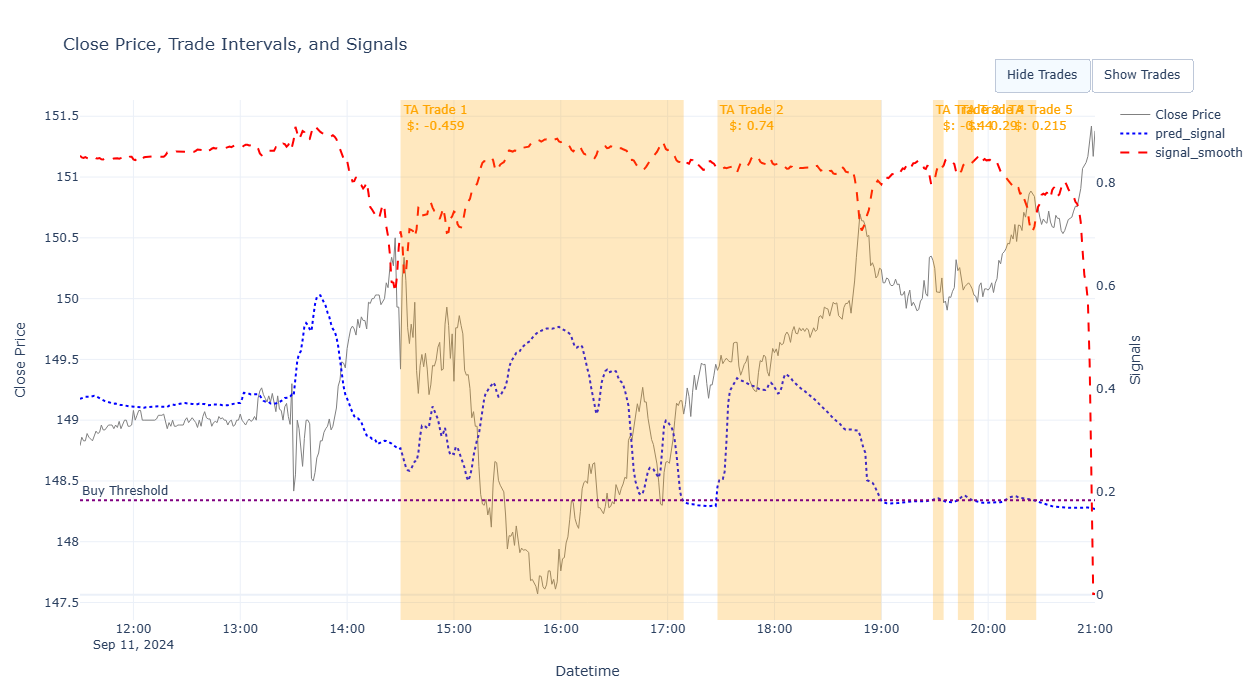


=== Performance for 2024-09-11 00:00:00 ===
Strategy Return ($): -0.235
Buy & Hold Return ($): 1.66
Trades Returns ($): [-0.459, 0.74, -0.44, -0.29, 0.215]


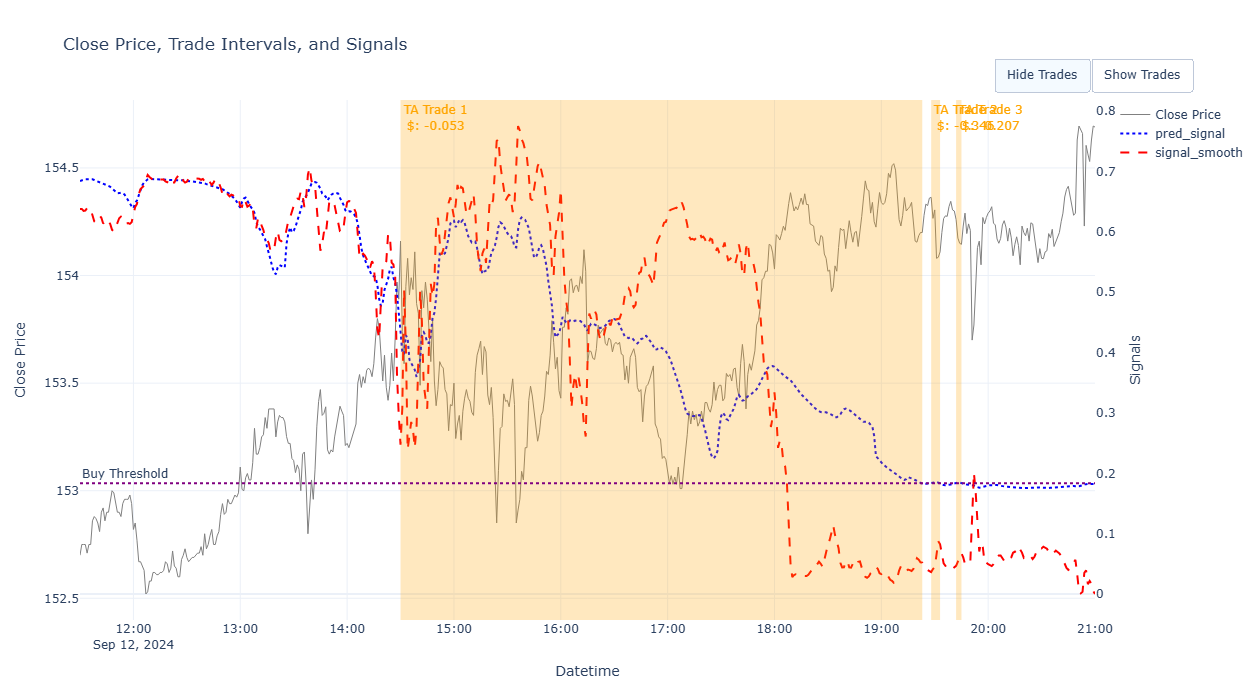


=== Performance for 2024-09-12 00:00:00 ===
Strategy Return ($): -0.606
Buy & Hold Return ($): 0.442
Trades Returns ($): [-0.053, -0.346, -0.207]


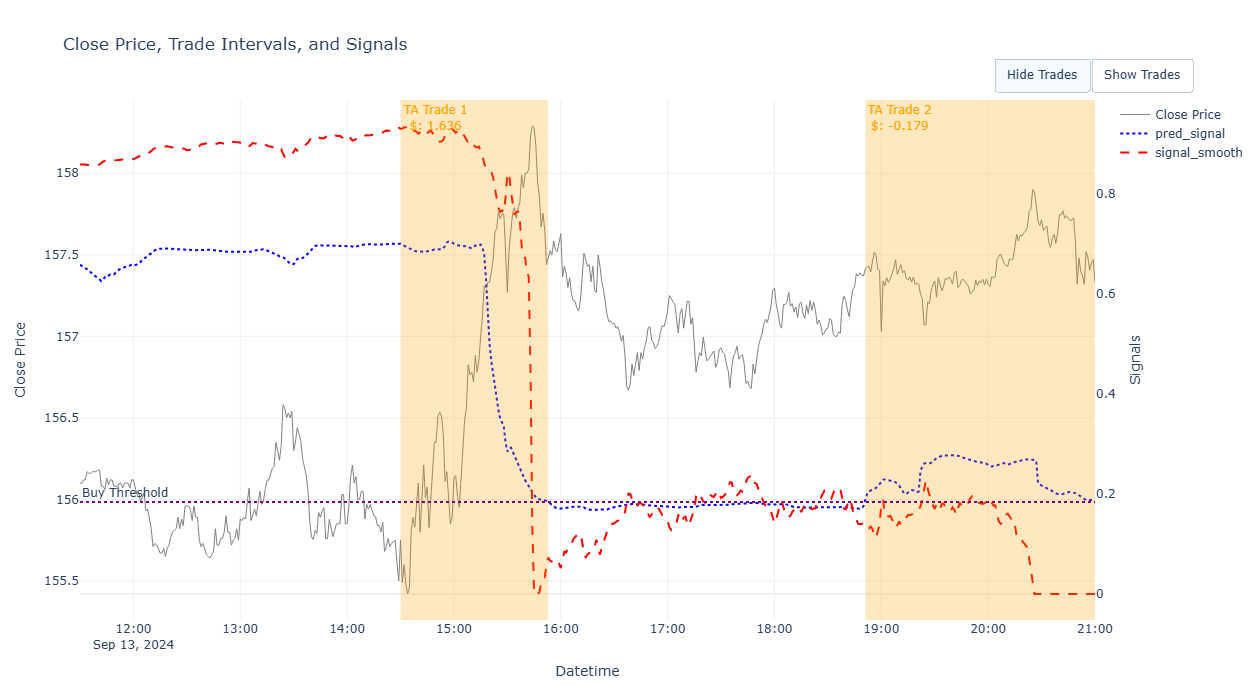


=== Performance for 2024-09-13 00:00:00 ===
Strategy Return ($): 1.597
Buy & Hold Return ($): 1.626
Trades Returns ($): [1.636, -0.179]


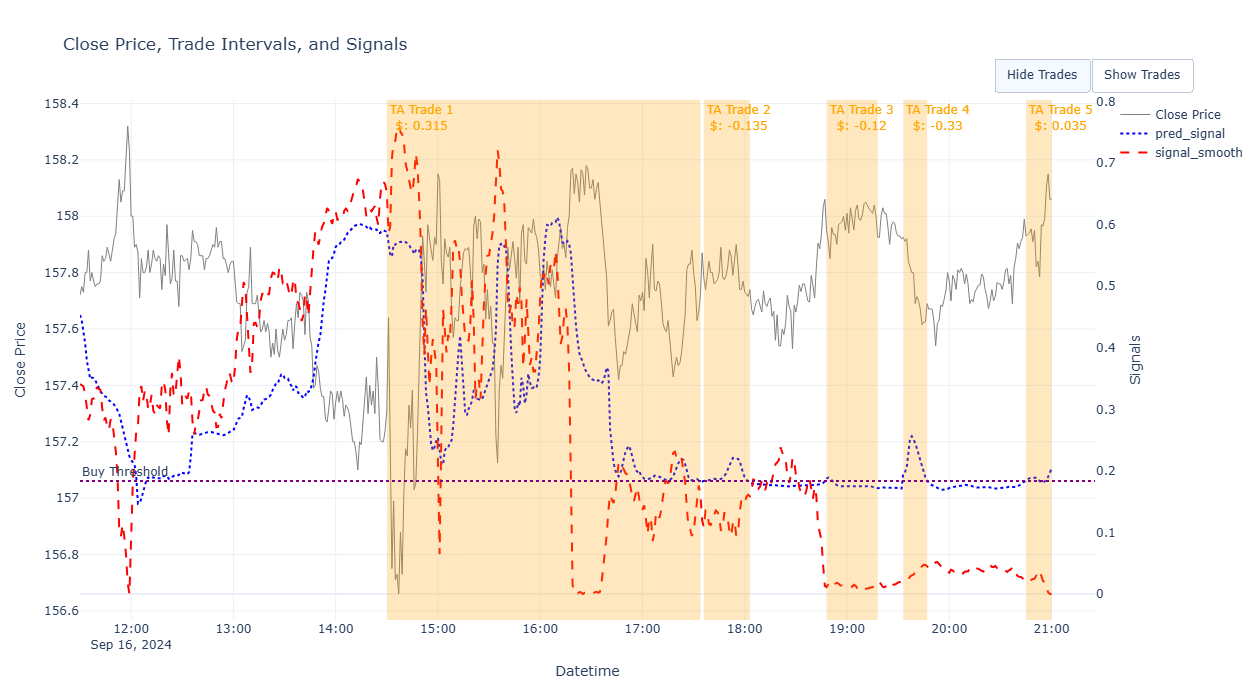


=== Performance for 2024-09-16 00:00:00 ===
Strategy Return ($): -0.234
Buy & Hold Return ($): 0.655
Trades Returns ($): [0.315, -0.135, -0.12, -0.33, 0.035]


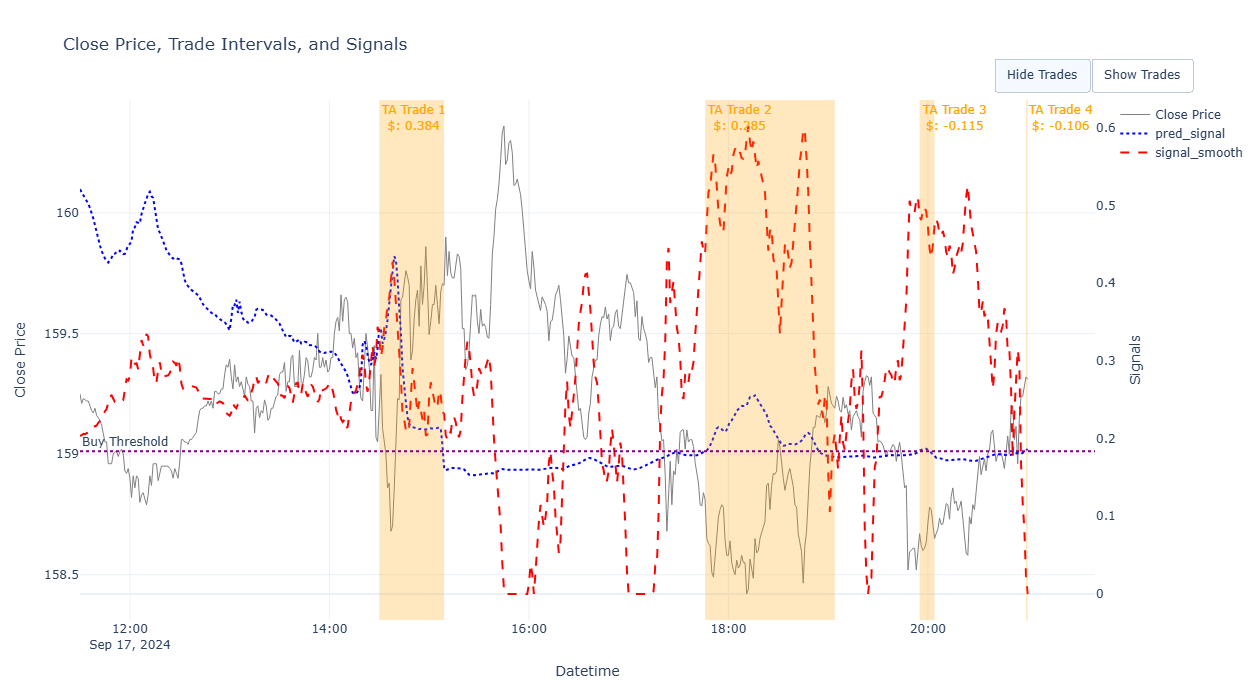


=== Performance for 2024-09-17 00:00:00 ===
Strategy Return ($): 0.458
Buy & Hold Return ($): 0.004
Trades Returns ($): [0.384, 0.285, -0.115, -0.106]


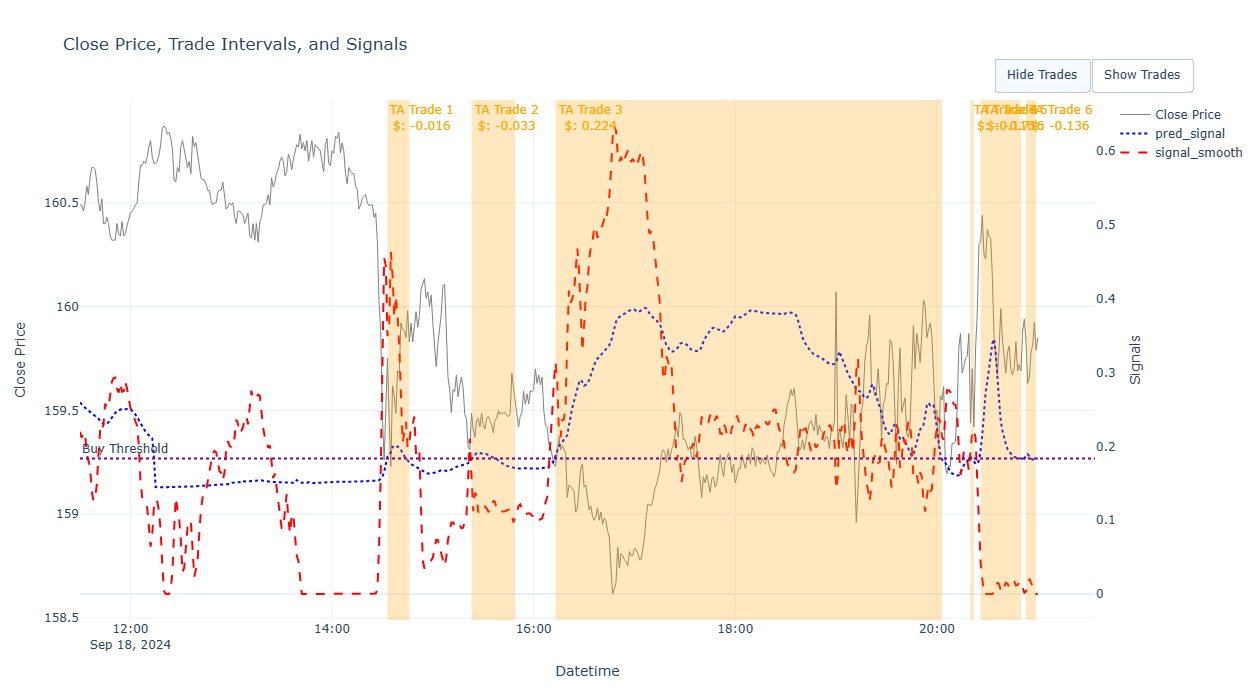


=== Performance for 2024-09-18 00:00:00 ===
Strategy Return ($): -0.791
Buy & Hold Return ($): 0.228
Trades Returns ($): [-0.016, -0.033, 0.224, -0.116, -0.716, -0.136]


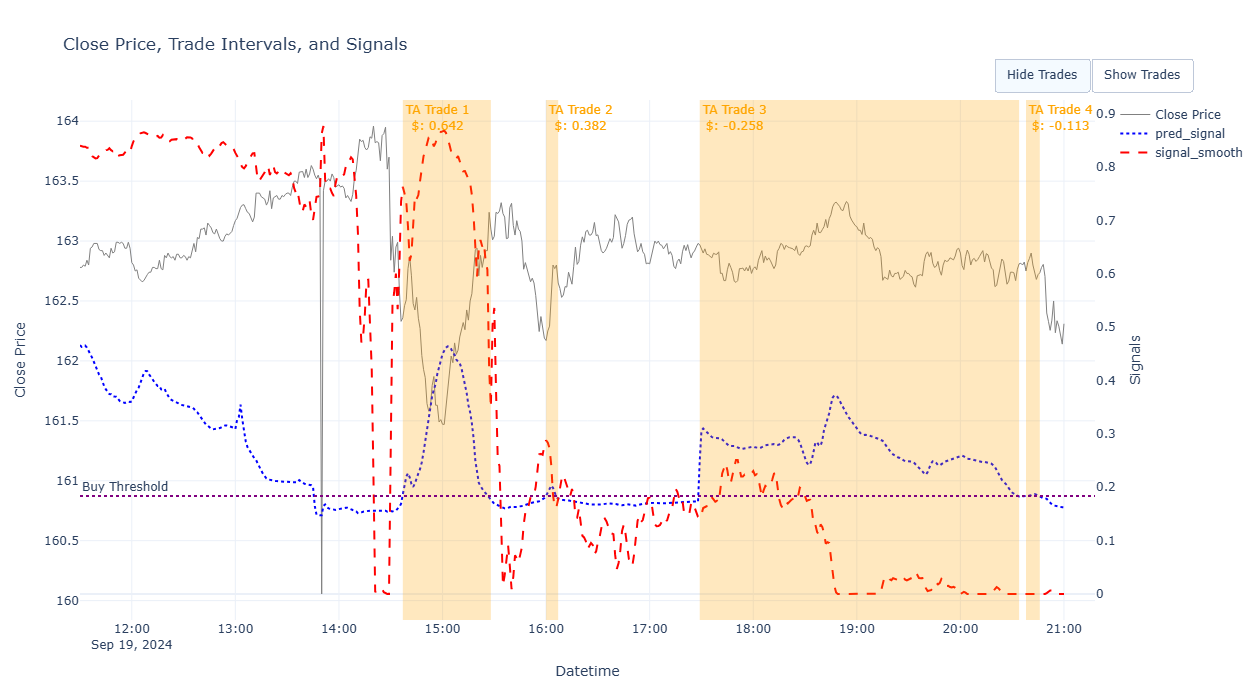


=== Performance for 2024-09-19 00:00:00 ===
Strategy Return ($): 0.655
Buy & Hold Return ($): -0.798
Trades Returns ($): [0.642, 0.382, -0.258, -0.113]


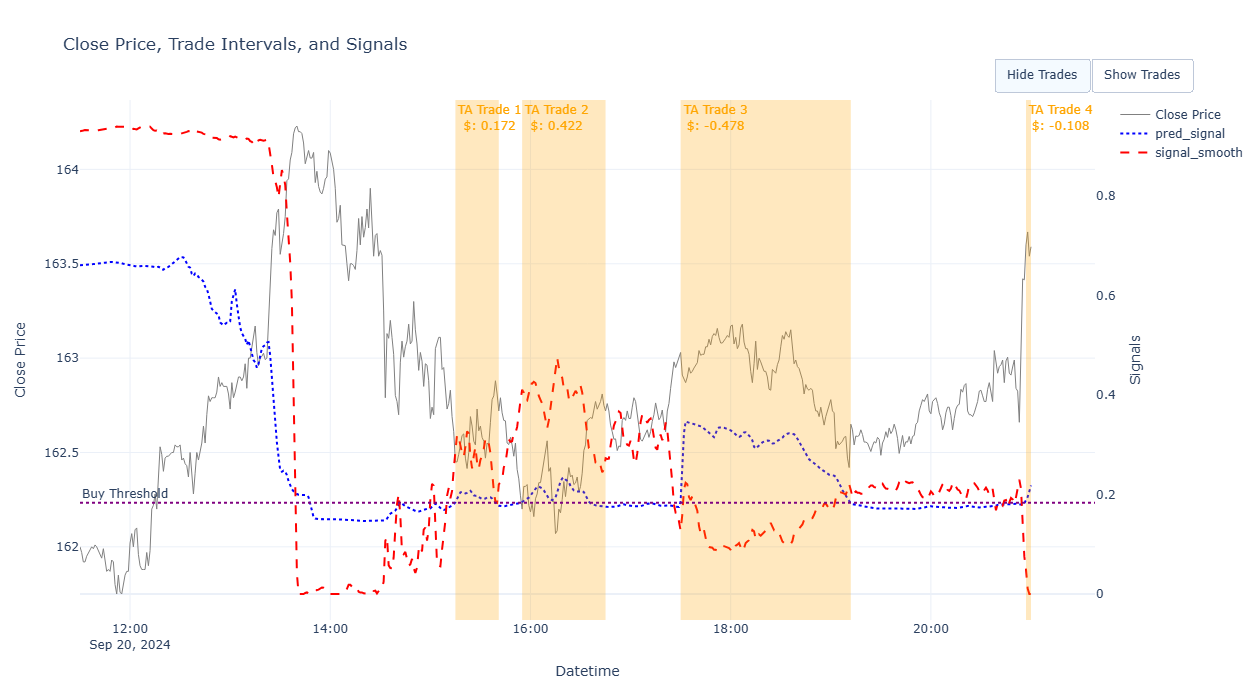


=== Performance for 2024-09-20 00:00:00 ===
Strategy Return ($): -0.041
Buy & Hold Return ($): -0.128
Trades Returns ($): [0.172, 0.422, -0.478, -0.108]


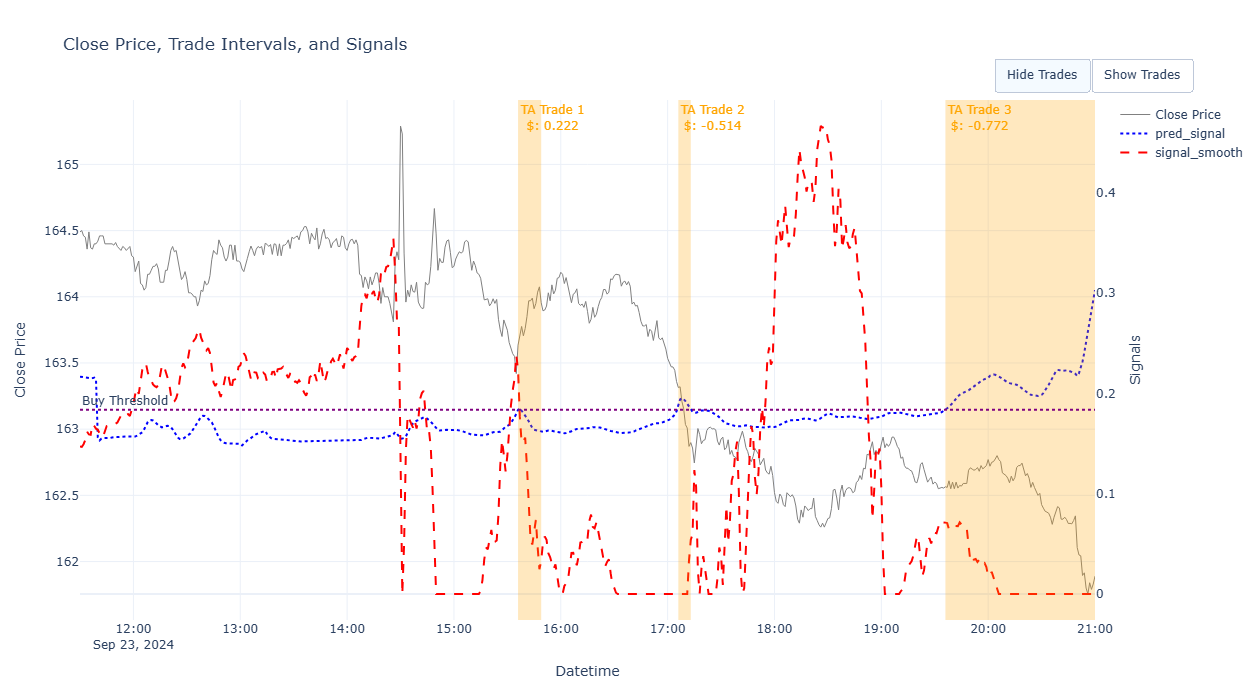


=== Performance for 2024-09-23 00:00:00 ===
Strategy Return ($): -1.125
Buy & Hold Return ($): -3.558
Trades Returns ($): [0.222, -0.514, -0.772]


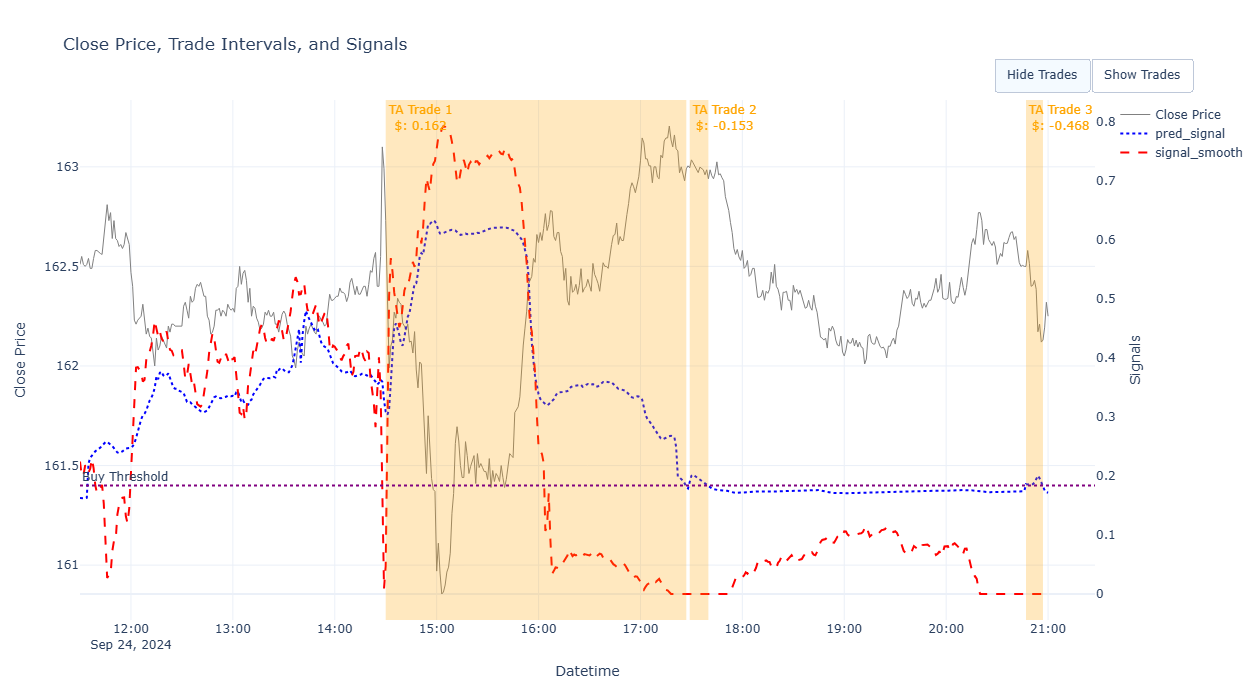


=== Performance for 2024-09-24 00:00:00 ===
Strategy Return ($): -0.458
Buy & Hold Return ($): -0.507
Trades Returns ($): [0.162, -0.153, -0.468]


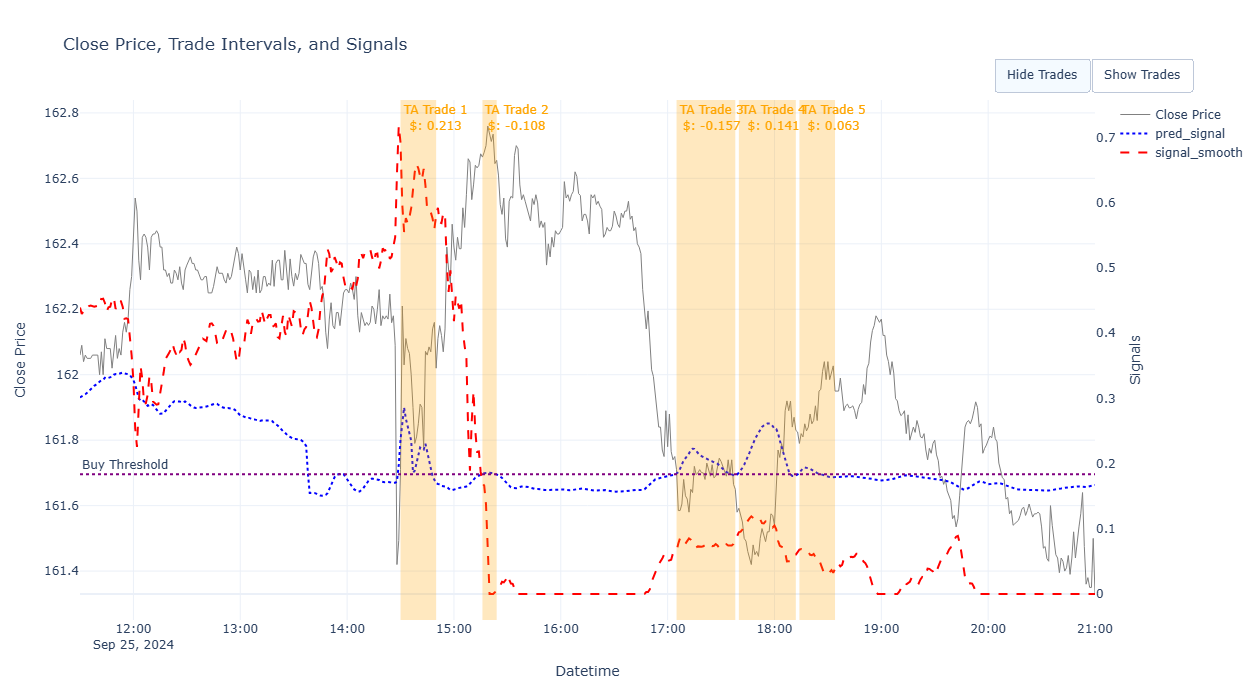


=== Performance for 2024-09-25 00:00:00 ===
Strategy Return ($): 0.152
Buy & Hold Return ($): -0.307
Trades Returns ($): [0.213, -0.108, -0.157, 0.141, 0.063]


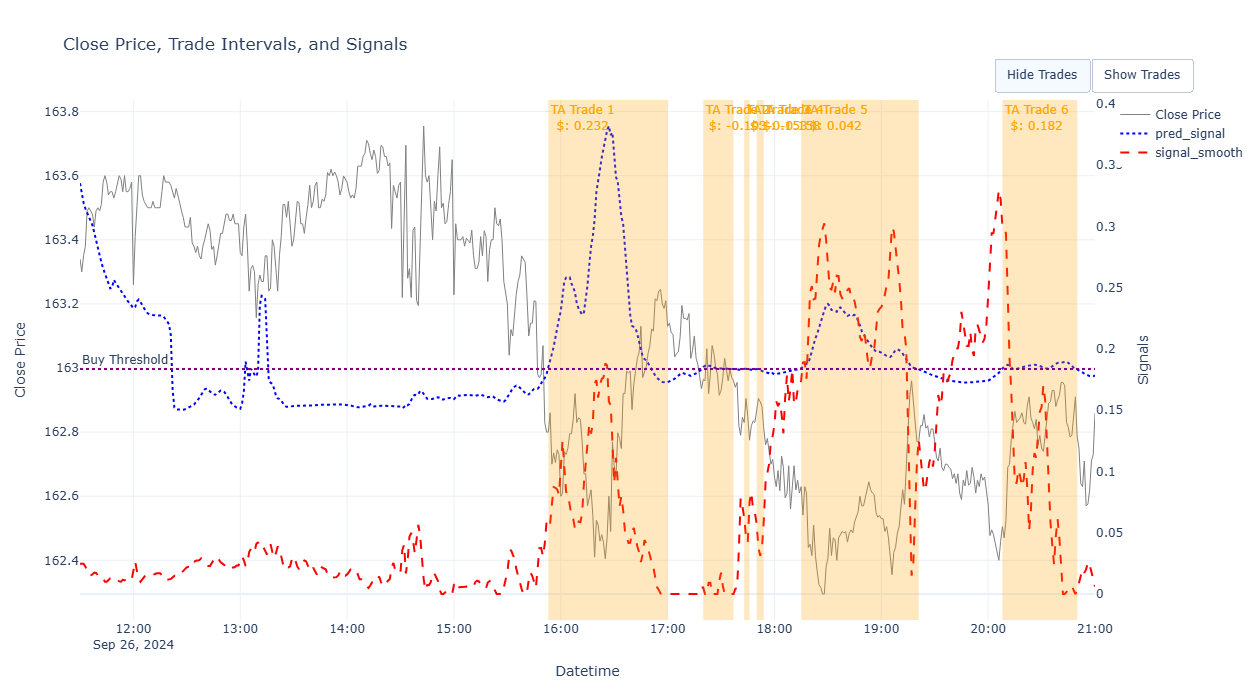


=== Performance for 2024-09-26 00:00:00 ===
Strategy Return ($): 0.044
Buy & Hold Return ($): -0.948
Trades Returns ($): [0.232, -0.103, -0.153, -0.158, 0.042, 0.182]


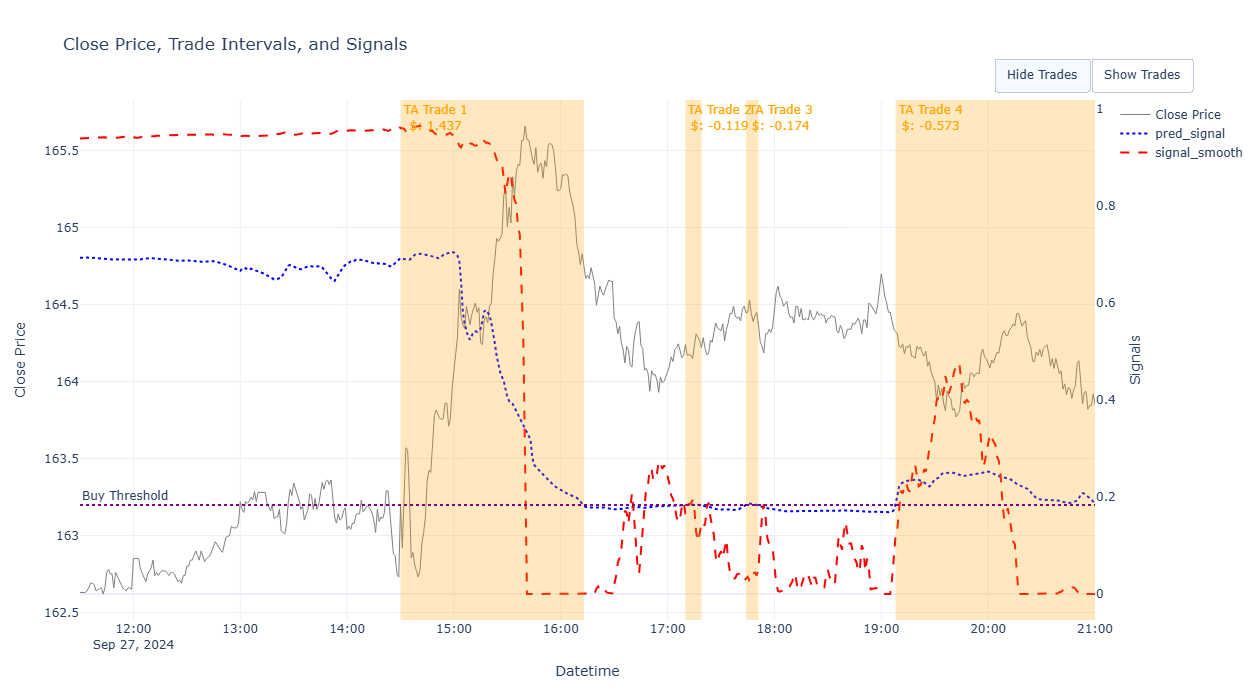


=== Performance for 2024-09-27 00:00:00 ===
Strategy Return ($): 0.641
Buy & Hold Return ($): 0.627
Trades Returns ($): [1.437, -0.119, -0.174, -0.573]


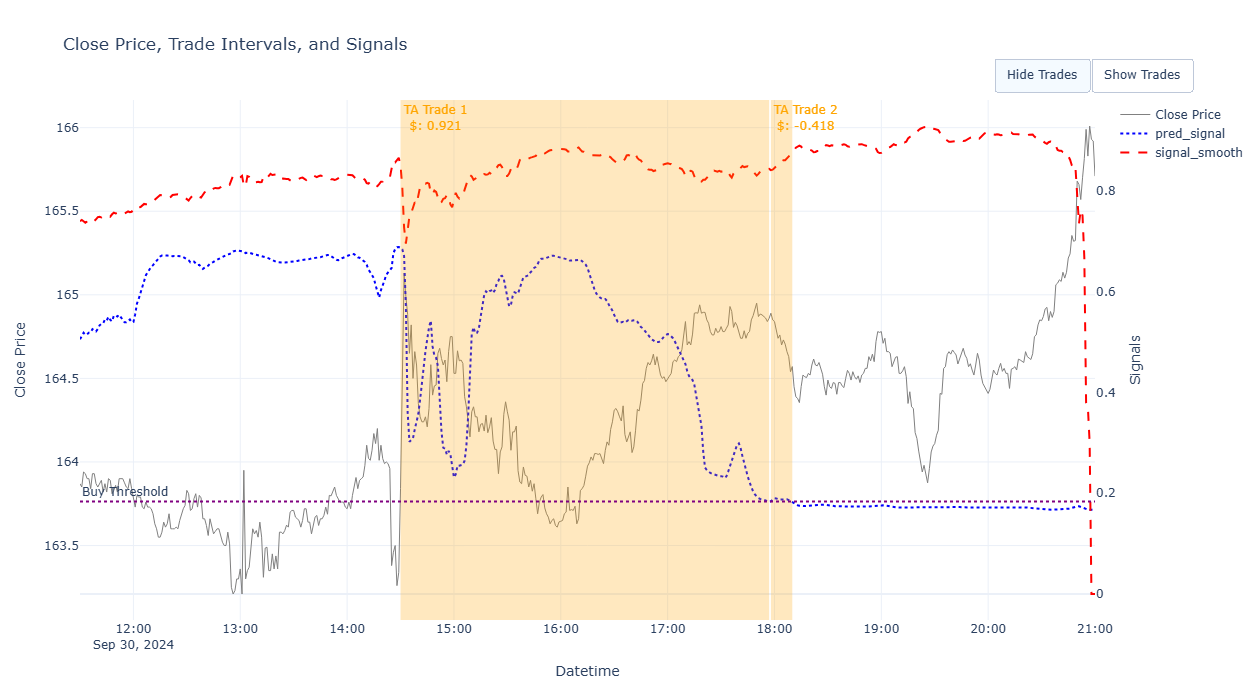


=== Performance for 2024-09-30 00:00:00 ===
Strategy Return ($): 0.503
Buy & Hold Return ($): 1.981
Trades Returns ($): [0.921, -0.418]

=== Overall Summary (2024-09-03 → 2024-09-30) ===
Start date price: 2024-09-03 = 161.4884
  End date price:  2024-09-30 = 165.6603
One-time buy&hold gain: 4.172

{'Buy & Hold – each day ($)': -16.897,
 'Strategy Return ($)': 0.74,
 'Trades Returns ($)': '76 trades'}

=== Overall Summary (2023-10-12 → 2025-06-18) ===
Start date price: 2023-10-12 = 140.4855
  End date price:  2025-06-18 = 173.5576
One-time buy&hold gain: 33.072

{'Buy & Hold – each day ($)': -77.566,
 'Strategy Return ($)': 254.3,
 'Trades Returns ($)': '1177 trades'}


In [29]:
# month to inspect (YYYY-MM)
date_to_test = params.date_to_test

year, month = map(int, date_to_test.split("-"))

# 1) Build lists of days in that month + accumulate ALL days
days_in_month = []
performance_month = []
performance_all   = []

for day, (df_sim, trades_list, perf_stats) in sim_results.items():
    # always collect for the global summary
    performance_all.append(perf_stats)

    # pick out this month for plotting
    if day.year == year and day.month == month:
        days_in_month.append(day)
        performance_month.append(perf_stats)

# 2) Plot & print per-day stats for the month
if not days_in_month:
    print(f"No simulation data for {date_to_test}")
else:
    print(f"\nPlotting days in {date_to_test}:")
    for day in days_in_month:
        df_sim, trades_list, perf_stats = sim_results[day]
        plots.plot_trades(
            df                = df_sim,
            col_signal1       = "pred_signal",
            col_signal2       = "signal_smooth",
            col_action        = "pred_action",
            trades            = trades_list,
            buy_threshold     = params.pred_threshold_tick,
            performance_stats = perf_stats
        )
        
        print(f"\n=== Performance for {day} ===")
        for k, v in perf_stats.items():
            print(f"{k}: {v}")

# 3) Monthly summary
df_month = df_with_preds[df_with_preds.index.to_period("M") == date_to_test]
monthly_summary = plots.aggregate_performance(performance_month, df_month)
pprint(monthly_summary)

# 4) Overall summary across ALL days, with date range
overall_summary = plots.aggregate_performance(performance_all, df_with_preds)
pprint(overall_summary)
